# Task 3: Thinking Deeper
## CS 462 - Fall 2025
Make the network "think" multiple times before deciding

theoretically, more thinking steps = better predictions

## Setup

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

import torch
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
CUDA: True
GPU: Tesla T4


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
import copy

sns.set_style('whitegrid')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Minesweeper Game

In [ ]:
class MinesweeperGame:
    def __init__(self, height=22, width=22, num_mines=80):
        self.height = height
        self.width = width
        self.num_mines = num_mines
        self.reset()

    def reset(self):
        self.mine_map = np.zeros((self.height, self.width), dtype=bool)
        positions = [(i, j) for i in range(self.height) for j in range(self.width)]
        mine_positions = random.sample(positions, self.num_mines)
        for i, j in mine_positions:
            self.mine_map[i, j] = True


        self.clue_map = np.zeros((self.height, self.width), dtype=int)
        for i in range(self.height):
            for j in range(self.width):
                if not self.mine_map[i, j]:
                    self.clue_map[i, j] = self._count_adjacent_mines(i, j)

        self.revealed = np.zeros((self.height, self.width), dtype=bool)
        self.game_over = False
        self.mine_triggered = False
        self.num_revealed = 0
        self._reveal_first_cell()
        return self.get_state()

    def _count_adjacent_mines(self, i, j):
        count = 0
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    if self.mine_map[ni, nj]:
                        count += 1
        return count

    def _reveal_first_cell(self):

        zero_cells = [(i, j) for i in range(self.height) for j in range(self.width)
                      if self.clue_map[i, j] == 0]
        if zero_cells:
            i, j = random.choice(zero_cells)
        else:
            non_mine_cells = [(i, j) for i in range(self.height) for j in range(self.width)
                             if not self.mine_map[i, j]]
            i, j = random.choice(non_mine_cells)
        self._reveal_cell_and_neighbors(i, j)

    def _reveal_cell_and_neighbors(self, i, j):
        if self.revealed[i, j]:
            return
        self.revealed[i, j] = True
        self.num_revealed += 1
        # auto-reveal neighbors if zero
        if self.clue_map[i, j] == 0:
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i + di, j + dj
                    if 0 <= ni < self.height and 0 <= nj < self.width:
                        if not self.revealed[ni, nj] and not self.mine_map[ni, nj]:
                            self._reveal_cell_and_neighbors(ni, nj)

    def step(self, i, j):
        if self.game_over or self.revealed[i, j]:
            return self.get_state(), 0, self.game_over, {'mine_triggered': self.mine_triggered}

        if self.mine_map[i, j]:
            self.revealed[i, j] = True
            self.num_revealed += 1
            self.game_over = True
            self.mine_triggered = True
            return self.get_state(), -1, True, {'mine_triggered': True}

        self._reveal_cell_and_neighbors(i, j)
        if self.num_revealed == self.height * self.width - self.num_mines:
            self.game_over = True
            return self.get_state(), 10, True, {'mine_triggered': False}
        return self.get_state(), 1, False, {'mine_triggered': False}

    def get_state(self):
        state = np.full((self.height, self.width), -1, dtype=int)
        state[self.revealed] = self.clue_map[self.revealed]
        return state

    def get_neighbors(self, i, j):
        neighbors = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    neighbors.append((ni, nj))
        return neighbors

print("game ready")

game ready


## Logic Bot (for data generation)

In [ ]:
class LogicBot:
    def __init__(self, game):
        self.game = game
        self.height = game.height
        self.width = game.width
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.cells_remaining = set((i, j) for i in range(self.height) for j in range(self.width))

    def play_game(self):
        state = self.game.reset()
        self._update_from_state(state)
        states = []

        while not self.game.game_over:
            states.append(state.copy())
            self._make_inferences(state)

            if self.inferred_safe:
                i, j = self.inferred_safe.pop()
            else:
                if not self.cells_remaining:
                    break
                i, j = random.choice(list(self.cells_remaining))

            state, _, done, info = self.game.step(i, j)
            self._update_from_state(state)

            if info.get('mine_triggered'):
                break

        return states

    def _update_from_state(self, state):
        for i in range(self.height):
            for j in range(self.width):
                if state[i, j] >= 0:
                    self.cells_remaining.discard((i, j))
                    self.inferred_safe.discard((i, j))
                    self.inferred_mine.discard((i, j))

    def _make_inferences(self, state):
        made_inference = True
        while made_inference:
            made_inference = False
            for i in range(self.height):
                for j in range(self.width):
                    if state[i, j] < 0:
                        continue
                    clue = state[i, j]
                    neighbors = self.game.get_neighbors(i, j)
                    unrevealed_neighbors = []
                    inferred_mine_neighbors = 0
                    revealed_or_safe_neighbors = 0
                    for ni, nj in neighbors:
                        if (ni, nj) in self.inferred_mine:
                            inferred_mine_neighbors += 1
                        elif state[ni, nj] >= 0 or (ni, nj) in self.inferred_safe:
                            revealed_or_safe_neighbors += 1
                        else:
                            unrevealed_neighbors.append((ni, nj))

                    if clue - inferred_mine_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_mine:
                                self.inferred_mine.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True

                    total_neighbors = len(neighbors)
                    if (total_neighbors - clue) - revealed_or_safe_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_safe:
                                self.inferred_safe.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True

print("logic bot ready")

logic bot ready


## Generate Training Data

In [ ]:
def state_to_tensor(state):
    # same as task 1
    revealed_mask = (state >= 0).astype(np.float32)
    clue_normalized = np.where(state >= 0, state / 8.0, 0).astype(np.float32)
    unrevealed_mask = (state < 0).astype(np.float32)
    tensor = np.stack([revealed_mask, clue_normalized, unrevealed_mask], axis=0)
    return torch.from_numpy(tensor)

def generate_data(num_games=3000):
    game = MinesweeperGame(num_mines=80)
    data = []

    for _ in tqdm(range(num_games), desc="generating data"):
        bot = LogicBot(game)
        states = bot.play_game()

        # save each state with ground truth mines
        for state in states:
            data.append((state, game.mine_map.copy()))

    print(f"collected {len(data)} training samples")
    return data

print("generating data...")
train_data = generate_data(num_games=3000)

generating data...


generating data:   0%|          | 0/3000 [00:00<?, ?it/s]

collected 228077 training samples


## Iterative Refinement Network

key idea: network takes board state + previous prediction, outputs refined prediction

run it multiple times to "think" longer

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class RefinementNetwork(nn.Module):
    def __init__(self):
        super(RefinementNetwork, self).__init__()
        # input: 3 channels (board state) + 1 channel (previous prediction) = 4 total
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(64) for _ in range(4)])

        # dilated convolutions for long-range dependencies
        self.conv_d1 = nn.Conv2d(64, 64, kernel_size=3, padding=2, dilation=2)
        self.bn_d1 = nn.BatchNorm2d(64)
        self.conv_d2 = nn.Conv2d(64, 64, kernel_size=3, padding=4, dilation=4)
        self.bn_d2 = nn.BatchNorm2d(64)

        # output
        self.conv_out1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_out1 = nn.BatchNorm2d(64)
        self.conv_out2 = nn.Conv2d(64, 1, kernel_size=1)

        self.dropout = nn.Dropout2d(0.3)

    def forward(self, board_state, prev_prediction):
        # concatenate board state and previous prediction
        x = torch.cat([board_state, prev_prediction], dim=1)

        x = F.relu(self.bn1(self.conv1(x)))

        for block in self.res_blocks:
            x = block(x)

        x = self.dropout(x)
        x = F.relu(self.bn_d1(self.conv_d1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_d2(self.conv_d2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_out1(self.conv_out1(x)))
        x = torch.sigmoid(self.conv_out2(x))

        return x.squeeze(1)

model = RefinementNetwork().to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()):,}")

parameters: 410,177


## Dataset

In [ ]:
class MinesweeperDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, mine_map = self.data[idx]
        state_tensor = state_to_tensor(state)
        target = torch.from_numpy(mine_map.astype(np.float32))
        return state_tensor, target

dataset = MinesweeperDataset(train_data)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(f"dataset size: {len(dataset)}")

dataset size: 228077


## Training

train with variable thinking steps (1 to 5)

loss weighted more for later steps (we want those to be better)

In [ ]:
def train_iterative_model(model, train_loader, num_epochs=15, lr=0.0005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCELoss(reduction='none')

    losses_by_step = {i: [] for i in range(6)}  # track loss for each step

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        step_losses = {i: 0 for i in range(6)}

        for states, targets in tqdm(train_loader, desc=f"epoch {epoch+1}/{num_epochs}", leave=False):
            states = states.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # random number of thinking steps (1 to 5)
            num_steps = random.randint(1, 5)

            # start with zero prediction
            pred = torch.zeros_like(targets).unsqueeze(1).to(device)

            total_loss = 0
            for step in range(num_steps + 1):
                pred = model(states, pred).unsqueeze(1)

                # compute loss
                unrevealed_mask = (states[:, 2:3, :, :] > 0)
                loss = criterion(pred.squeeze(1), targets)
                loss = (loss * unrevealed_mask.squeeze(1)).sum() / unrevealed_mask.sum()

                # weight later steps more
                weight = (step + 1)
                total_loss += weight * loss

                step_losses[step] += loss.item()

            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"epoch {epoch+1}/{num_epochs} - total loss: {avg_loss:.4f}")

        # track step losses
        for step in range(6):
            if step_losses[step] > 0:
                losses_by_step[step].append(step_losses[step] / len(train_loader))

    return losses_by_step

print("training model...")
step_losses = train_iterative_model(model, train_loader, num_epochs=15)

training model...


epoch 1/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 1/15 - total loss: 3.7979


epoch 2/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 2/15 - total loss: 3.5746


epoch 3/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 3/15 - total loss: 3.5249


epoch 4/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 4/15 - total loss: 3.4805


epoch 5/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 5/15 - total loss: 3.4103


epoch 6/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 6/15 - total loss: 3.4027


epoch 7/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 7/15 - total loss: 3.3535


epoch 8/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 8/15 - total loss: 3.3632


epoch 9/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 9/15 - total loss: 3.3059


epoch 10/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 10/15 - total loss: 3.1960


epoch 11/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 11/15 - total loss: 3.2927


epoch 12/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 12/15 - total loss: 3.2055


epoch 13/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 13/15 - total loss: 3.1699


epoch 14/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 14/15 - total loss: 3.1884


epoch 15/15:   0%|          | 0/3564 [00:00<?, ?it/s]

epoch 15/15 - total loss: 3.0995


## Evaluation 1: Loss vs Thinking Steps

test on some boards and see if loss decreases with more thinking

evaluating loss vs thinking steps...


evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


loss by thinking step:
  step 0: 0.2615 ± 0.1220
  step 1: 0.2044 ± 0.1317
  step 2: 0.1884 ± 0.1340
  step 3: 0.1834 ± 0.1344
  step 4: 0.1823 ± 0.1344
  step 5: 0.1826 ± 0.1341


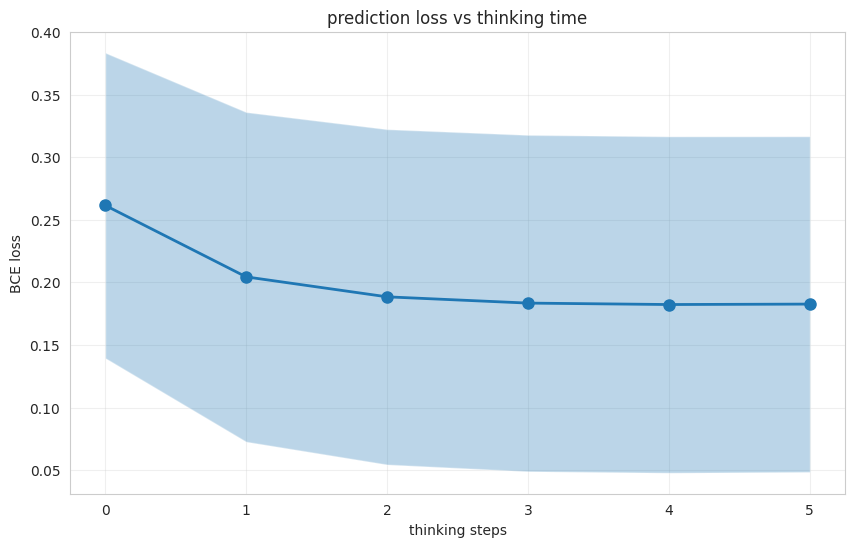

In [ ]:
def evaluate_loss_vs_steps(model, num_samples=100, max_steps=5):
    model.eval()
    criterion = nn.BCELoss(reduction='none')

    # get some test samples
    test_indices = random.sample(range(len(dataset)), num_samples)

    losses_by_step = {i: [] for i in range(max_steps + 1)}

    with torch.no_grad():
        for idx in tqdm(test_indices, desc="evaluating"):
            state, target = dataset[idx]
            state = state.unsqueeze(0).to(device)
            target = target.unsqueeze(0).to(device)

            pred = torch.zeros_like(target).unsqueeze(1)

            for step in range(max_steps + 1):
                pred = model(state, pred).unsqueeze(1)

                # compute loss on unrevealed cells only
                unrevealed_mask = (state[:, 2:3, :, :] > 0)
                loss = criterion(pred.squeeze(1), target)
                loss = (loss * unrevealed_mask.squeeze(1)).sum() / unrevealed_mask.sum()

                losses_by_step[step].append(loss.item())

    # average losses
    avg_losses = {step: np.mean(losses) for step, losses in losses_by_step.items()}
    std_losses = {step: np.std(losses) for step, losses in losses_by_step.items()}

    return avg_losses, std_losses

print("evaluating loss vs thinking steps...")
avg_losses, std_losses = evaluate_loss_vs_steps(model, num_samples=200)

print("\nloss by thinking step:")
for step, loss in avg_losses.items():
    print(f"  step {step}: {loss:.4f} ± {std_losses[step]:.4f}")

# plot
plt.figure(figsize=(10, 6))
steps = list(avg_losses.keys())
losses = list(avg_losses.values())
stds = list(std_losses.values())

plt.plot(steps, losses, 'o-', linewidth=2, markersize=8)
plt.fill_between(steps,
                 [l - s for l, s in zip(losses, stds)],
                 [l + s for l, s in zip(losses, stds)],
                 alpha=0.3)
plt.xlabel('thinking steps')
plt.ylabel('BCE loss')
plt.title('prediction loss vs thinking time')
plt.grid(True, alpha=0.3)
plt.show()

## Evaluation 2: Bot Performance vs Thinking Steps

play actual games with different thinking times

In [ ]:
class IterativeBot:
    def __init__(self, model, thinking_steps=3):
        self.model = model
        self.thinking_steps = thinking_steps
        self.model.eval()

    def play_game(self, game):
        state = game.reset()
        moves = 0

        while not game.game_over and moves < 200:
            # get prediction with thinking steps
            state_tensor = state_to_tensor(state).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = torch.zeros(1, 1, 22, 22).to(device)
                for _ in range(self.thinking_steps + 1):
                    pred = self.model(state_tensor, pred).unsqueeze(1)

                mine_probs = pred.squeeze().cpu().numpy()

            # pick safest unrevealed cell
            unrevealed_mask = (state < 0)
            if not unrevealed_mask.any():
                break

            masked_probs = np.where(unrevealed_mask, mine_probs, 1.0)
            i, j = np.unravel_index(masked_probs.argmin(), masked_probs.shape)

            state, _, done, info = game.step(i, j)
            moves += 1

            if info.get('mine_triggered'):
                break

        return moves, not game.mine_triggered

def evaluate_bot_performance(model, thinking_steps_list=[0, 1, 2, 3, 4, 5], num_games=100):
    game = MinesweeperGame(num_mines=80)
    results = {}

    for steps in thinking_steps_list:
        bot = IterativeBot(model, thinking_steps=steps)
        moves_list = []
        wins = 0

        for _ in tqdm(range(num_games), desc=f"steps={steps}", leave=False):
            moves, won = bot.play_game(game)
            moves_list.append(moves)
            if won:
                wins += 1

        results[steps] = {
            'avg_moves': np.mean(moves_list),
            'std_moves': np.std(moves_list),
            'win_rate': wins / num_games
        }

        print(f"steps {steps}: {np.mean(moves_list):.1f} moves, {100*wins/num_games:.1f}% wins")

    return results

print("evaluating bot performance...")
performance_results = evaluate_bot_performance(model, num_games=100)

evaluating bot performance...


steps=0:   0%|          | 0/100 [00:00<?, ?it/s]

steps 0: 76.2 moves, 3.0% wins


steps=1:   0%|          | 0/100 [00:00<?, ?it/s]

steps 1: 121.4 moves, 37.0% wins


steps=2:   0%|          | 0/100 [00:00<?, ?it/s]

steps 2: 117.1 moves, 34.0% wins


steps=3:   0%|          | 0/100 [00:00<?, ?it/s]

steps 3: 104.5 moves, 28.0% wins


steps=4:   0%|          | 0/100 [00:00<?, ?it/s]

steps 4: 81.2 moves, 21.0% wins


steps=5:   0%|          | 0/100 [00:00<?, ?it/s]

steps 5: 60.2 moves, 9.0% wins


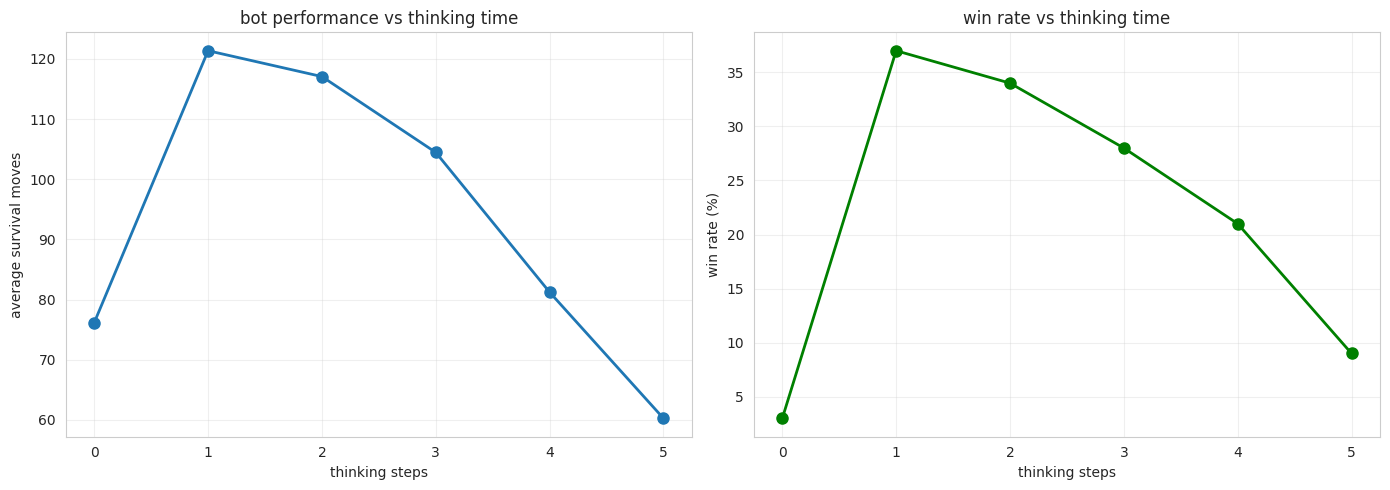

In [ ]:
# plot performance vs thinking steps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = list(performance_results.keys())
avg_moves = [performance_results[s]['avg_moves'] for s in steps]
win_rates = [performance_results[s]['win_rate'] * 100 for s in steps]

# survival moves
axes[0].plot(steps, avg_moves, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('thinking steps')
axes[0].set_ylabel('average survival moves')
axes[0].set_title('bot performance vs thinking time')
axes[0].grid(True, alpha=0.3)

# win rate
axes[1].plot(steps, win_rates, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('thinking steps')
axes[1].set_ylabel('win rate (%)')
axes[1].set_title('win rate vs thinking time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation 3: Heat Map Evolution

visualize how predictions change with more thinking

visualizing thinking process...


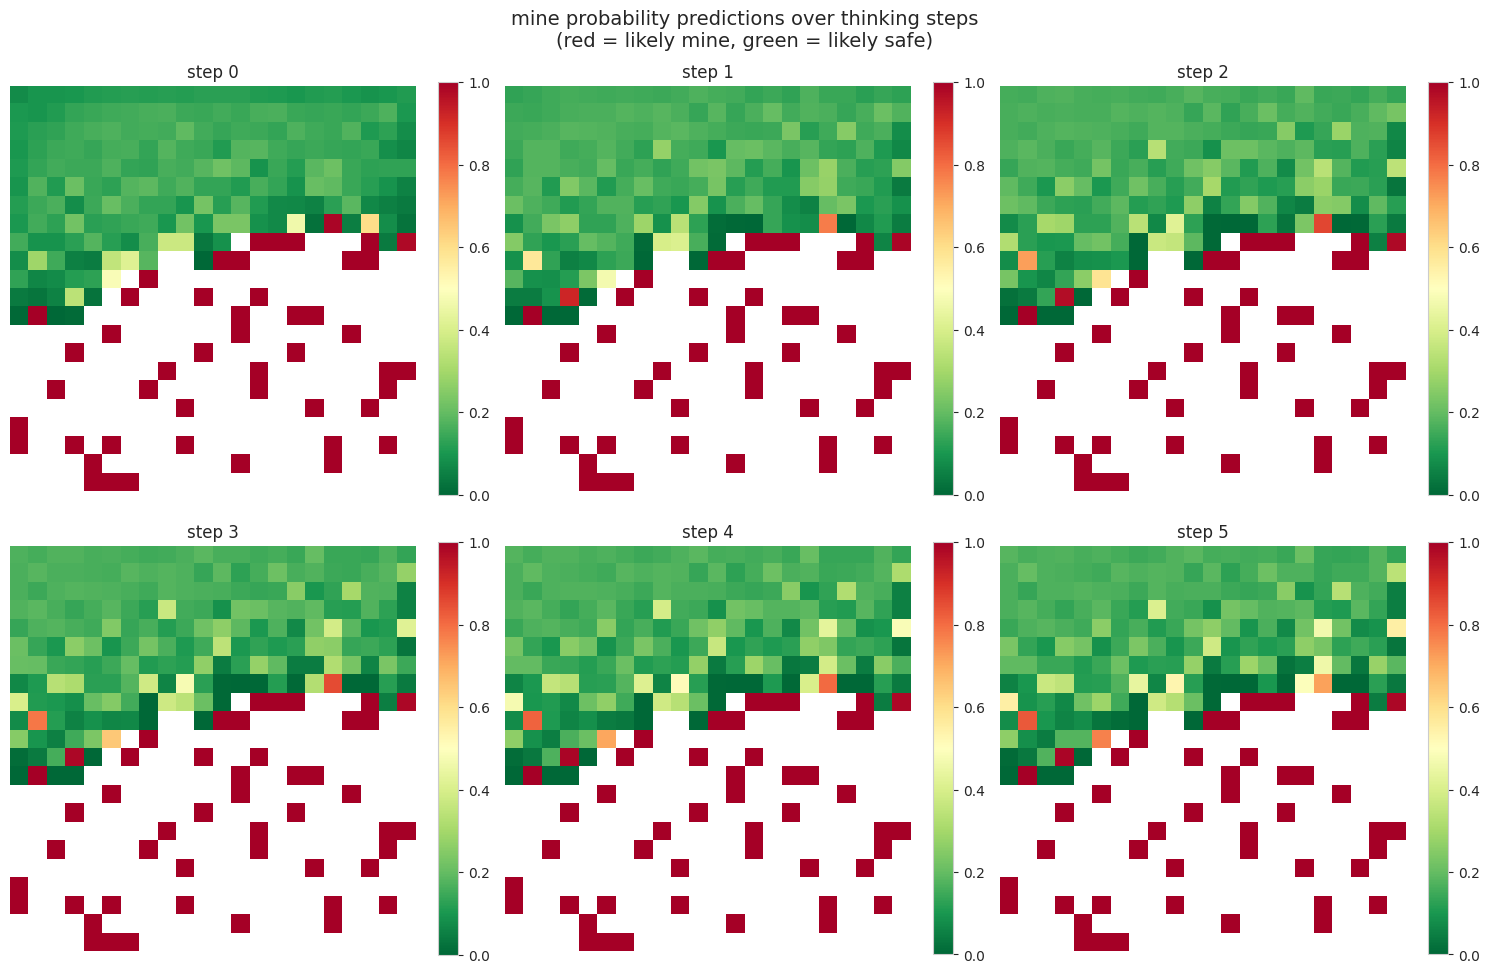

ValueError: cannot convert float NaN to integer

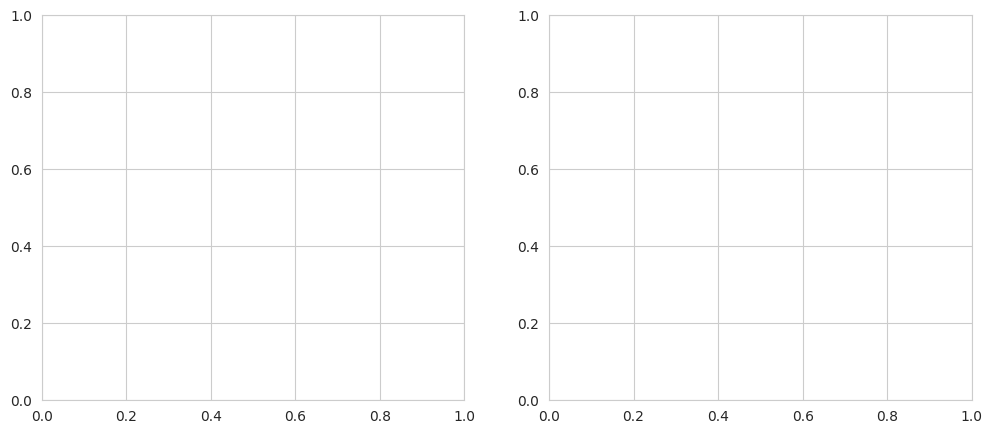

In [ ]:
def visualize_thinking_process(model, max_steps=5):
    # get a random game state
    game = MinesweeperGame(num_mines=80)
    bot = LogicBot(game)
    states = bot.play_game()

    # pick a state partway through game
    state = states[len(states) // 2]
    state_tensor = state_to_tensor(state).unsqueeze(0).to(device)

    model.eval()
    predictions = []

    with torch.no_grad():
        pred = torch.zeros(1, 1, 22, 22).to(device)

        for step in range(max_steps + 1):
            pred = model(state_tensor, pred).unsqueeze(1)
            predictions.append(pred.squeeze().cpu().numpy())

    # plot evolution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for step in range(max_steps + 1):
        ax = axes[step]

        # show prediction with unrevealed cells highlighted
        pred_display = predictions[step].copy()
        pred_display[state >= 0] = np.nan  # hide revealed cells

        im = ax.imshow(pred_display, cmap='RdYlGn_r', vmin=0, vmax=1)
        ax.set_title(f'step {step}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle('mine probability predictions over thinking steps\n(red = likely mine, green = likely safe)',
                 fontsize=14)
    plt.tight_layout()
    plt.show()

    # also show the actual board state
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # revealed clues
    display_state = state.copy()
    display_state[state < 0] = np.nan
    axes[0].imshow(display_state, cmap='viridis', vmin=0, vmax=8)
    axes[0].set_title('revealed clues')
    axes[0].axis('off')

    # actual mines
    axes[1].imshow(game.mine_map, cmap='RdYlGn_r')
    axes[1].set_title('actual mine locations')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("visualizing thinking process...")
visualize_thinking_process(model, max_steps=5)

## Summary Statistics

In [ ]:
print("="*70)
print("TASK 3 RESULTS SUMMARY")
print("="*70)

print("\n1. LOSS VS THINKING STEPS:")
for step, loss in avg_losses.items():
    improvement = 0 if step == 0 else (avg_losses[0] - loss) / avg_losses[0] * 100
    print(f"   step {step}: {loss:.4f} ({improvement:+.1f}% vs step 0)")

print("\n2. BOT PERFORMANCE VS THINKING STEPS:")
for steps in sorted(performance_results.keys()):
    res = performance_results[steps]
    print(f"   step {steps}: {res['avg_moves']:.1f} moves, {res['win_rate']*100:.1f}% wins")



TASK 3 RESULTS SUMMARY

1. LOSS VS THINKING STEPS:
   step 0: 0.2615 (+0.0% vs step 0)
   step 1: 0.2044 (+21.8% vs step 0)
   step 2: 0.1884 (+27.9% vs step 0)
   step 3: 0.1834 (+29.9% vs step 0)
   step 4: 0.1823 (+30.3% vs step 0)
   step 5: 0.1826 (+30.2% vs step 0)

2. BOT PERFORMANCE VS THINKING STEPS:
   step 0: 76.2 moves, 3.0% wins
   step 1: 121.4 moves, 37.0% wins
   step 2: 117.1 moves, 34.0% wins
   step 3: 104.5 moves, 28.0% wins
   step 4: 81.2 moves, 21.0% wins
   step 5: 60.2 moves, 9.0% wins


## Save Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'loss_results': avg_losses,
    'performance_results': performance_results
}, 'task3_iterative_model.pth')

print("model saved")

if IN_COLAB:
    !cp task3_iterative_model.pth /content/drive/MyDrive/
    print("also saved to google drive")

model saved
also saved to google drive
